In [1]:
import sys
import numpy as np

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm

# -- CONSTANT VARS ---
num_waypoints = 10
RADIUS = 10
circle_center = [0, -5., -30.]

LOOPS = 1

SEARCH_RADIUS = 2 * np.pi * RADIUS / num_waypoints
EPSILON = 2.

# -- END CONSTANT VARS -- 

string = "with rad {}, center at {}, num_waypoints {}, epsilon {:.2}, & SEARCH_RADIUS {:.2}...".format(
    RADIUS, circle_center, num_waypoints, EPSILON, SEARCH_RADIUS)

theta = np.linspace(0, 2*np.pi * LOOPS, num_waypoints)

theta_perpen = theta + np.pi / 2
waypoint_coords = np.vstack((circle_center[0] + RADIUS*np.cos(theta), #x
                             circle_center[1] + RADIUS*np.sin(theta), #y
                             circle_center[2] * np.ones(num_waypoints), #z
                             theta_perpen))                             # attitude


def sign(x):
    return -1 if x < 0 else 1

In [2]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 

from IPython.display import HTML, display
sys.path.insert(0, '../')
from flightgoggles.env import *

if __name__ == "__main__":
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = waypoint_coords.T[0][:3],
                          attitude_euler_angle=np.array([0., 0., waypoint_coords.T[0][3]]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = waypoint_coords.T[0]
    
    time_counter = 0
    crash = False
    for waypoint in waypoint_coords.T:
        prev_waypoint = curr_waypoint
        curr_waypoint = waypoint
                
        while np.linalg.norm(curr_pos - curr_waypoint[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            
            if (np.array_equal(curr_waypoint, waypoint_coords.T[-1])):
                target_pose = curr_waypoint
                EPSILON = 0.1
            else:
                x1 = prev_waypoint[0] - curr_pos[0]
                x2 = curr_waypoint[0] - curr_pos[0]
                y1 = prev_waypoint[1] - curr_pos[1]
                y2 = curr_waypoint[1] - curr_pos[1]
                
                dx = x2 - x1
                dy = y2 - y1
                dr = np.sqrt(dx*dx + dy*dy)
                det = x1 * y2 - x2 * y1
                
                if SEARCH_RADIUS**2 * dr**2 - det**2 < 0:
                    print("CRASH MSG ONLY FOR CONVENIENCE. OTHER PROBLEMS HAVE OCCURRED")
                    crash = True
                    break
                
                x1 = (det * dy + sign(dy) * dx * np.sqrt(SEARCH_RADIUS**2 * dr**2 - det**2)) / dr**2
                y1 = (-det * dx + np.abs(dy) * np.sqrt(SEARCH_RADIUS**2 * dr**2 - det**2)) / dr**2
                
                x2  = (det * dy - sign(dy) * dx * np.sqrt(SEARCH_RADIUS**2 * dr**2 - det**2)) / dr**2
                y2 = (-det * dx - np.abs(dy) * np.sqrt(SEARCH_RADIUS**2 * dr**2 - det**2)) / dr**2
                
                pt1 = np.array([x1, y1, curr_waypoint[2]])
                pt2 = np.array([x2, y2, curr_waypoint[2]])

                
                target_pose = None
                if (np.linalg.norm(curr_waypoint[:3] - pt2) > np.linalg.norm(curr_waypoint[:3] - pt1)):
                    target_pose = pt1
                else:
                    target_pose = pt2
                
                print(target_pose)
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])
                
                # HOW TO CHANGE THIS?
                target_pose = np.append(target_pose, att_to_target) # attitude

            collided = env.proceed_waypoint(vehicle_id="uav1",
                                            waypoint_command=target_pose,
                                            duration=0.01)
    
            rand_accumulator = np.append(rand_accumulator, target_pose[3])
    
#             if per_accumulator is None:
#                 per_accumulator = np.array([curr_pos_perpend])
#             else:
#                 per_accumulator = np.vstack((per_accumulator, curr_pos_perpend))

            if fol_accumulator is None:
                fol_accumulator = np.array([target_pose])
            else:
                fol_accumulator = np.vstack((fol_accumulator, target_pose))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
    
    f = open("observation notes continuous point circular.txt", "a")
    if not crash:
        f.write(string + " it took {:.2f} sec\n".format(time_counter))
    else:
        f.write(string + " it crashed :(\n")
    f.close()
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=200)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()












[  2.14897594  -5.90426287 -30.        ]
[  2.14898988  -5.90425779 -30.        ]
[  2.14899405  -5.90425628 -30.        ]
[  2.14897858  -5.90426191 -30.        ]
[  2.14894636  -5.90427363 -30.        ]
[  2.14891539  -5.90428491 -30.        ]
[  2.1488627   -5.90430408 -30.        ]
[  2.14876961  -5.90433796 -30.        ]
[  2.14870552  -5.90436128 -30.        ]
[  2.1486399   -5.90438517 -30.        ]
[  2.14856828  -5.90441123 -30.        ]
[  2.14848039  -5.90444321 -30.        ]
[  2.14838533  -5.9044778  -30.        ]
[  2.14831367  -5.90450387 -30.        ]
[  2.1482303   -5.90453421 -30.        ]
[  2.14812747  -5.90457162 -30.        ]
[  2.14801928  -5.90461097 -30.        ]
[  2.1478856   -5.90465961 -30.        ]
[  2.1477505   -5.90470875 -30.        ]
[  2.14752869  -5.90478942 -30.        ]
[  2.14724789  -5.90489154 -30.        ]
[  2.14696934  -5.90499283 -30.        ]
[  2.14661488  -5.90512169 -30.        ]
[  2.14625757  -5.90525156 -30.        ]
[  2.

AttributeError: 'NoneType' object has no attribute 'T'

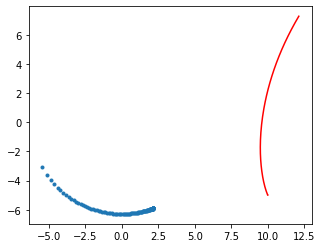

In [4]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(fol_accumulator.T[0], fol_accumulator.T[1], '.')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1], 'r')
plt.plot(per_accumulator.T[0], per_accumulator.T[1], 'g')
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o')

print(per_accumulator)

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(rand_accumulator.size)
y = rand_accumulator
#linear with a gap b/c pi to -pi
plt.plot(x, y, marker='.')